# E-commerce — Выявление профилей потребления

В рамках исследования пользовательского опыта интернет-магазин товаров для дома "Пока все ещё тут" выдвинул задачу выявления профилей покупателей. Датасет, выделенный для анализа, описывает транзакции интернет-магазина товаров за период с октября 2018 по октярбь 2019 

**Цель исследования** 

Провести сегментизацию пользователей на основе истории их покупок для настройки таргетинга и предложения персональных рекомендаций.

Для достижения цели были выдвинуты следующие задачи:

- провести иследовательский анализ данных
- сделать сегметизацию по потребительскому поведению
- применить статистические методы к сравнению средних чеков у разных сегментов
- дополнить сегментизацию по потребительскими предпочтениям
- Описать полученные сегменты и дать реккомендации по взаимодействию с ними

**Декомпозиция**

1. Общая информация 
 - знакомстов с данными, краткое описание
 - предобработка и подготовка к анализу 
 **  **
2. Исследовательский анализ данных

 - распределение суммы заказв 
 - распределение количества заказов 
 - сезонность данных
 - анализ среднего чека 
 ** **
 
3. Сегментизация пользователей  
 - критерии сегментирования
 - статистическая проверка
** **

4. Потребительские предпочтения

 - анализ ассортимента товаров и выделение категорий 
 - дополненение сегментизации 
 ** **
 
5. Выводы и реккомендации

## Общая информация

In [1]:
#импортируем все необходимые библиотеки 
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
import numpy as np

from scipy import stats as st

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px 
from plotly import graph_objects as go

from pymystem3 import Mystem

import requests 
from bs4 import BeautifulSoup 

In [2]:
#выведем первые строки датасета и информацию о нем
import pandas as pd

df = pd.read_csv('C:/Users/alfro/Documents/Daria_Jupyter/Datasets/ecommerce_dataset.csv')

display(df.head())
df.info()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


В датасете даны описания транзаций интернет-магазина товаров для дома и быта «Пока все ещё тут». Каждая строка соотвествует одной позиции в заказе, описанной по следущим столбцам: 
- `date`- дата покупки 
- `customer_id`- идентификатор покупателя 
- `order_id`- идентификатор заказа
- `product` - наименование товара
-  `quantity`- количесво товара в заказе 
- `price`- цена

Всего в таблице 6737 строк и 6 столбцов. Имена столбцов даны в удобном виде, очевидных пропусков в данных нет.У пяти столбцов  типы данных пригодны для работы, а вот колонку `date` стоит привести к типу datetime

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
#df.head()

Также выполним проверку на наличие полных дубликатов 

In [4]:
print('Количество полных дубликатов:', 
        df.duplicated().sum())

Количество полных дубликатов: 0


Также приведем в описании некую общую информацию, описывающую датасет. 

In [5]:
print('Временные рамки траназакций:', 
     df['date'].min(), '-', df['date'].max())

print('Количесвто уникальных пользователей:',
      df['customer_id'].nunique())

print('Количество уникальных заказов:', 
     df['order_id'].nunique())

print('Количесвто уникальных товаров', 
     df['product'].nunique())

#df.sample(5)

Временные рамки траназакций: 2018-10-01 00:00:00 - 2019-10-31 16:00:00
Количесвто уникальных пользователей: 2451
Количество уникальных заказов: 2784
Количесвто уникальных товаров 2343


Данные за 13 месяцев и примерно о 2500 клиентах. Количесво заказов не намного больше количесва клиентав, что говорит об относительно малом проценте повторных заказов. Ассортимент товаров довольно широк, при этом они никак не разбит по категориям 

### Вывод

Данные корректных типов, без явных дубликатов и пропусков, готову к анализу 

## Исследовательский анализ данных 

### Суммы заказов

Посчитаем сколько денег принес каждый заказ магазину. Для этого создадим колонку, которая будет считать сумму денег за полученный товар (если, например его больше 1 единицы, то умножать на количество). Затем сгруппируем датасет по заказу и клиенту

In [6]:
df['price_sum'] = df['price'] * df['quantity']
df.sample(5)

,date,customer_id,order_id,product,quantity,price,price_sum
1588,2019-01-24 15:00:00,ac070679-0e88-4d63-af67-2277896d9451,69958,Гипоаллергенный концентрированный гель для сти...,1,539.0,539.0
6689,2019-10-24 20:00:00,6952bdf7-5b29-4fb4-90a4-a7a325825aed,73083,Искусственный цветок Гербера пластиковая розовая,2,29.0,58.0
3721,2019-05-13 20:00:00,bb09b7b4-8b6a-485a-8323-fadb0e547e9e,14765,Петуния махровая рассада однолетних цветов в к...,1,210.0,210.0
2045,2019-02-27 01:00:00,24e8d333-ba61-4296-84b3-2ea572dfd6cd,70476,Роза мини желтая d-7 см h-10,1,187.0,187.0
5527,2019-06-22 00:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурец Кристина ячейки по 6 шт Е6,1,120.0,120.0


In [7]:
orders = df.groupby(['customer_id','order_id']).agg({'price_sum' : 'sum'}).reset_index()
orders.head()

,customer_id,order_id,price_sum
0,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,70290,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,72965,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,69990,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,72796,2324.0


Нарисуем гистограмму и боксплот по колонке с суммой денег 

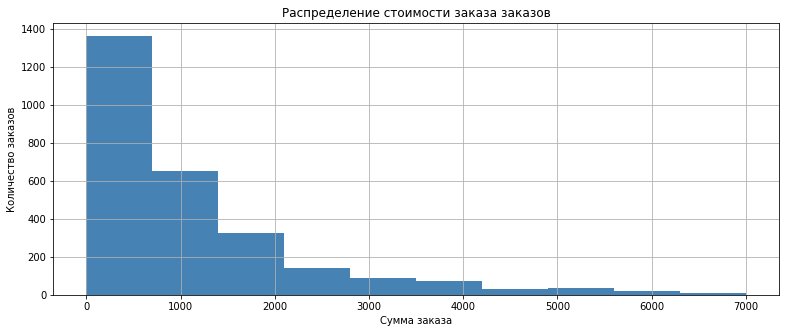

In [8]:
plt.figure(figsize=(13, 5)) 

orders['price_sum'].hist(range=(0, 7000),  color='steelblue')

plt.xlabel('Сумма заказа')
plt.ylabel('Количество заказов')
plt.title('Распределение стоимости заказа заказов')
plt.show()


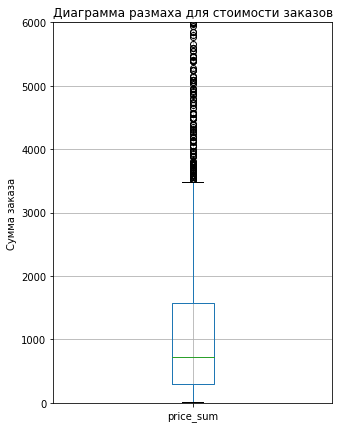

In [9]:
plt.figure(figsize=(5, 7)) 

orders.boxplot(column = 'price_sum')
plt.ylim(0, 6000)

plt.ylabel('Сумма заказа')
plt.title('Диаграмма размаха для стоимости заказов')
plt.show()

In [10]:
orders['price_sum'].describe()

count      2817.000000
mean       1722.144125
std       13213.892802
min          14.000000
25%         300.000000
50%         727.000000
75%        1574.000000
max      675000.000000
Name: price_sum, dtype: float64

Разброс по стоимости заказов очень велик. На гистограмме видно, что основная масса заказов не превышает 1000 руб, а 3/4 всех заказов находятся в районе 1500 руб. Однако есть и огромные заказы на стотни тысяч рублей. Показательна в этом плане мединанная стоимость заказа 727 руб - если нам нужно сказать сколько в среднем люди платят за заказ, то нужно ориентироваться на эту метрику. Рассмотрим самые дорогие заказы (дороже 40000)

In [11]:
df.query('price_sum > 40000')

,date,customer_id,order_id,product,quantity,price,price_sum
1518,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,Простынь вафельная 200х180 см WELLNESS RW180-0...,27,1755.0,47385.0
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0


1000 вантузов, 334 набора вешалок и 27 простыней - не самые обычные заказы в интернет-магазине, похоже на какие-то промышленные закупки. Может быть с этими клиетами стоит связаться отдельно и предложить им какие-то оптовые закупки, но для анализа эти заказы лучше удалить из датасетаб чтобы они не перекашивали данные 

In [12]:
df = df.query('order_id != 69830 and order_id != 71743 and order_id != 71668')
orders = orders.query('order_id != 69830 and order_id != 71743 and order_id != 71668')

Это были единичные огромные заказы, также посмотрим и на те заказы, суммы которых невероятно велики 

In [13]:
orders.query('price_sum > 50000')

,customer_id,order_id,price_sum
307,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,114750.0
924,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,65220.0
1667,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,50770.0


In [14]:
display(df.query('order_id == 70960').head())
len(df.query('order_id == 70960'))

,date,customer_id,order_id,product,quantity,price,price_sum
2589,2019-04-01 16:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,1087.0
2600,2019-04-02 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,1087.0
2622,2019-04-03 08:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,1087.0
2718,2019-04-07 15:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,1087.0
2734,2019-04-08 09:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,1087.0


60

Исследвательский анализ данных показал, что в датасете пристсвуют неявные дубликаты - например, этот заказ каким-то образом размножился по временам, хотя номер заказа, айди покупателя и айди заказа везде оставаля прежним. Поищем нет ли в таблице еще таких размноженных строк 

In [15]:
df_dubcheck = df.drop(['date'], axis = 1)

print('Количество неявных дубликатов:', 
    df_dubcheck.duplicated().sum())

Количество неявных дубликатов: 1864


Получается, что более четверти записей всех транзакций размножились во времени - похоже на какую-то техническую неисправность. Стоит срочно проверить то, как собираются данные. Подобные дубликаты из анализа нужно исключить 


In [16]:
df = df.drop_duplicates(['customer_id', 'order_id', 'product', 'quantity', 'price'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 6735
Data columns (total 7 columns):
date           4870 non-null datetime64[ns]
customer_id    4870 non-null object
order_id       4870 non-null int64
product        4870 non-null object
quantity       4870 non-null int64
price          4870 non-null float64
price_sum      4870 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 304.4+ KB


In [17]:
orders = df.groupby(['customer_id','order_id']).agg({'price_sum' : 'sum'}).reset_index()
orders['price_sum'].describe()

count     2814.000000
mean      1197.703269
std       1831.296652
min         14.000000
25%        284.250000
50%        680.000000
75%       1438.500000
max      33680.000000
Name: price_sum, dtype: float64

В очишенных данных картина слегка поменялась и нормализовалась - максимальный заказ теперь в районе 30 000, а медиана 680. Однако также актуальным и осталось то, что большинство заказов сравнительно очень недорогие. 

### Количесвто заказов 

In [18]:
orders_n = df.groupby('customer_id')['order_id'].nunique().reset_index()
orders_n.head()

,customer_id,order_id
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1
1,001cee7f-0b29-4716-b202-0042213ab038,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1


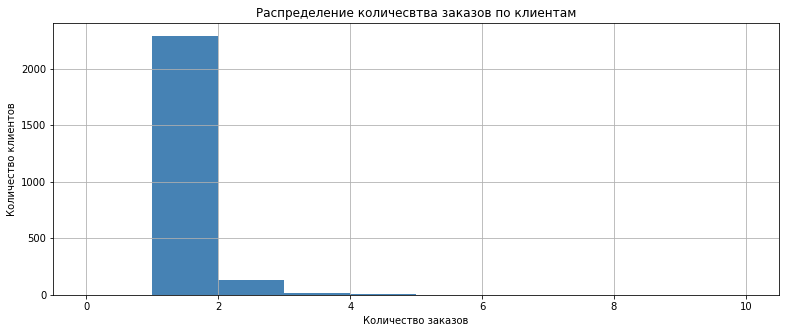

In [19]:
plt.figure(figsize=(13, 5)) 

orders_n['order_id'].hist(bins = 10, range=(0, 10), color='steelblue')

plt.xlabel('Количество заказов')
plt.ylabel('Количество клиентов')
plt.title('Распределение количесвтва заказов по клиентам')
plt.show()

In [20]:
print('Процент клиентов, которые совершили более одного заказа:{:.1%}'.
      format(len(orders_n.query("order_id > 1")) / len(orders_n)))

Процент клиентов, которые совершили более одного заказа:6.5%


Как видно из гистограммы в абсолютном большинсве клиенты совершают один заказ - только около 6% возвращаются. Это довольно странно, учитывая, что данные более, чем за годовой период (возможно это значит, что в магазине необязательна регистрация (и тогда мы просто не отслеживаем повторных покупталей, что не очень дальновидно)). Тем не менее пдробно рассмотрим тех, кто вернулся 

In [21]:
orders_n.query("order_id > 1").sort_values(by = 'order_id', ascending=False ).head(10)

,customer_id,order_id
1914,c971fb21-d54c-4134-938f-16b62ee86d3b,126
740,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1099,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1746,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
17,0184f535-b60a-4914-a982-231e3f615206,5
697,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
2145,e0535076-6270-4df2-8621-cb06264a94fa,4
1818,bea7a833-2074-42db-bc49-4457abd3c930,4
802,552e17df-ba16-4e66-84fb-55a5557a6bea,3
876,5d566073-92e8-41d1-a2e6-d301ee5ab6d8,3


Есть покупатель, который покупал в разы больше, чем все остальные в базе, посмотрим на него подробнее 

In [22]:
df.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"').head(10)

,date,customer_id,order_id,product,quantity,price,price_sum
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0,674.0
20,2018-10-02 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68490,Чехол для гладильной доски Festival 137x60 см ...,1,1162.0,1162.0
64,2018-10-03 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68511,Набор прищепок большие пластиковые ROZENBAL ПИ...,10,86.0,860.0
65,2018-10-03 10:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68514,Сушилка для белья Attribute ПРИМА 11 м синяя н...,1,749.0,749.0
130,2018-10-08 07:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68561,Тележка багажная DELTA ТБР-20 коричневый с ора...,1,742.0,742.0
131,2018-10-08 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68562,Готовая скатерть Ажурная Dia Rose круглая д.15...,1,712.0,712.0
132,2018-10-08 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68563,Сушилка для белья потолочная Zalger Lift Basic...,1,614.0,614.0
139,2018-10-08 13:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68568,"Таз пластмассовый 18,0 л квадратный (ТП-18) ""П...",1,254.0,254.0
160,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,"Стяжка оконная с болтом СТ-55 цинк, 1108354",64,19.0,1216.0
171,2018-10-10 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68596,Сумка-тележка 3-х колесная Gimi Tris Floral синяя,1,2699.0,2699.0


In [23]:
print('Сумма денег от самого верного покупателя:', 
      df.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"')['price_sum'].sum())

Сумма денег от самого верного покупателя: 159508.0


Непохоже на то, что это был бы дубликат, видимо, клиент действительно очень часто и много покупает в нашем магазине. Однако, это очень нетипично, потому что пока все говорит о том, что наш основной покупатель - тот, кто делает 1 заказ на сумму до 1000 руб 

### Сезонность данных 

Посмотрим на распределение заказов относительно того времени, когда они совершались - построим графики по сумме и количесвту заказов по месяцам)

In [24]:
df['date_month'] = df['date'].astype('datetime64[M]').dt.strftime('%Y-%m') 

orders_season = df.groupby('date_month').agg({'order_id' : 'nunique', 'price_sum' : 'sum'}).reset_index()
#orders_season

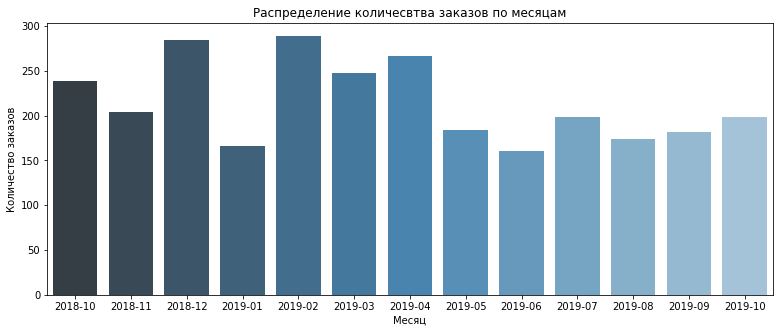

In [25]:
plt.figure(figsize=(13, 5)) 
sns.barplot(x = 'date_month', y = 'order_id', data = orders_season, palette="Blues_d")

plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Распределение количесвтва заказов по месяцам')
plt.show()

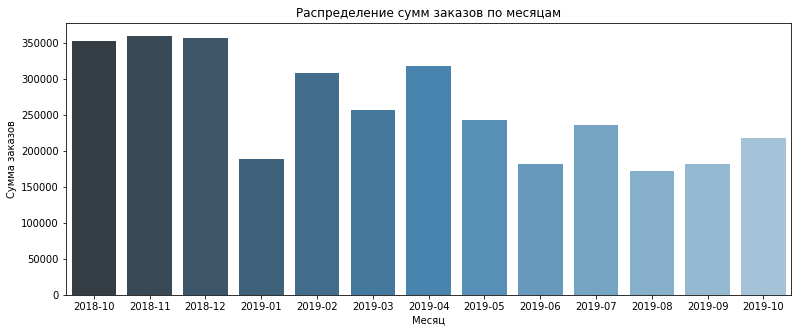

In [26]:
plt.figure(figsize=(13, 5)) 

sns.barplot(x = 'date_month', y = 'price_sum', data = orders_season,  palette="Blues_d")

plt.xlabel('Месяц')
plt.ylabel('Сумма заказов')
plt.title('Распределение сумм заказов по месяцам')
plt.show()

Если мы говорим и выручке за месяц, то можно сказать, что октябрь, ноябрь и декабрь были самые прибыльные месяцы. По количесву заказов самые продуктивные - декабрь и апрель. Декабрь прибыльный во всех отношениях (а январь соотвесвенно самый менее прибыльный) из-за новогодних праздников, апрель тоже можно отметить как месяд подготовки к дачному сезону, а вот то, что в октябре и ноябре прибыль была довольно высока, а количество заказов средним, указывает на большее количесво крупных заказов. Похоже в это время были активнее наши "нетипичные клиенты" (условно те кто совершают заказы дороже 1000 руб. Возможно, были какие-то акции или магазин только открылся и успешно привлек много таких клиентов. 
Также видна довольно тревожная тендеция трех последних месяцев - и заказы, и сумма заказов относительно всего прошешего периодна не очень высоки.

### Средний чек

In [27]:
df.head()

,date,customer_id,order_id,product,quantity,price,price_sum,date_month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0,2018-10
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10


In [28]:
customers = df.groupby('customer_id').agg({'price_sum' : 'sum', 'order_id' : 'nunique' }).reset_index()
customers.columns = ['customer_id', 'sum', 'orders_n']
customers.head()

,customer_id,sum,orders_n
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,1
1,001cee7f-0b29-4716-b202-0042213ab038,442.0,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,914.0,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,1


In [29]:
customers['mean_check'] = customers['sum'] / customers['orders_n']
display(customers.head())
customers['mean_check'].describe()

,customer_id,sum,orders_n,mean_check
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,1,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,442.0,1,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,914.0,1,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,1,2324.0


count     2449.000000
mean      1197.253078
std       1844.339330
min         14.000000
25%        292.000000
50%        674.000000
75%       1447.000000
max      33680.000000
Name: mean_check, dtype: float64

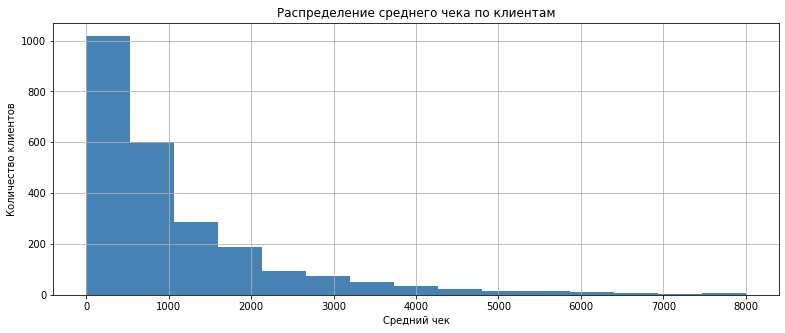

In [30]:
plt.figure(figsize=(13, 5)) 

customers['mean_check'].hist(bins = 15, range=(0, 8000), color='steelblue')

plt.xlabel('Средний чек')
plt.ylabel('Количество клиентов')
plt.title('Распределение среднего чека по клиентам')
plt.show()

Так ка у нас очень мало повторных заказов, то распределение среднего чего ожидаемо очень похоже на распределение стоимости заказа, поэтому и выводы те же самые: более половины всез покупателей в среднем оставляют в магазине менее 700 за один заказ. Так же стоит заметить, что не так велик разброс между теми, кто оставляет в магазине 2000 или 3000, поэтому можно говорить о том, что у нас 2 категории покупателей - те у кого высокий средний чек и те у кого низкий, а границей можно выбрать 3ий квантиль 1447 руб 

In [31]:
border = np.percentile(customers['mean_check'], 75)
border

1447.0

Интересно было бы посмотреть сколько денег в общую выручку приносят  клиенты каждой группы, однако как мы помним по боксплоту по стоимости заказов в нашем датасете довольно много выбросов. Если посчиать процент денег, которые приносят клиенты с высоким среднем чеком от всей выручки ожидаемо получится значительно больше, так как все выбросы на огромные суммы здесь. Поэтому временно отрежем, все, что за границей верхнего уса боксплота 

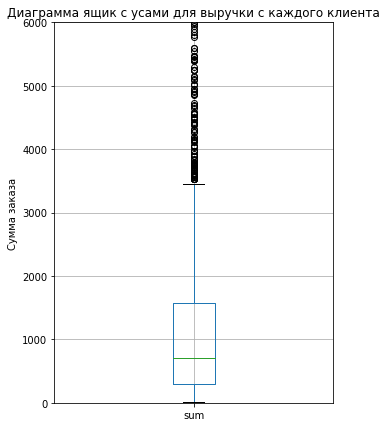

In [32]:
plt.figure(figsize=(5, 7)) 

customers.boxplot(column = 'sum')
plt.ylim(0, 6000)

plt.ylabel('Сумма заказа')
plt.title('Диаграмма ящик с усами для выручки с каждого клиента')
plt.show()


In [33]:
q1 = customers['sum'].quantile(0.25)
q3 = customers['sum'].quantile(0.75)
iqr = q3 - q1

customers_cut = customers.query('sum <= @q3 + 1.5 * @iqr')

print("Мы отрезали {:.1%} данных".
      format(1 - customers_cut.shape[0] / customers.shape[0]))

Мы отрезали 7.5% данных


Получилось довольно много клиентов, поэтоу отрезаем эти данные не насовсем, а для того, чтобы понять сколько в среднем приносит каждая группа. Клиентов без выбросов разделим на 2 группы по среднему чеку и посмотрим сколько приносят клиенты в каждой группе относительно всей выручки

In [34]:
low_check = customers_cut.query('mean_check <= @border')
high_check = customers_cut.query('mean_check > @border')

In [35]:
print('Клиентов с низким средним чеком: {}'.format(len(low_check)))
print('Клиентов с высоким средним чеком: {}'.format(len(high_check)))

Клиентов с низким средним чеком: 1833
Клиентов с высоким средним чеком: 432


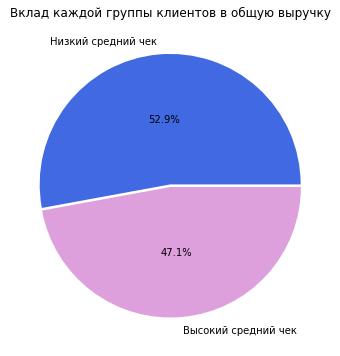

In [36]:
plt.figure(figsize=(6, 6)) 

colors = [ 'royalblue', 'plum']  # slateblue','lightsteelblue', 'rebeccapurple'
plt.pie(np.array([low_check['sum'].sum(), high_check['sum'].sum()]),
        autopct="%.1f%%", explode=[0.01]*2,
       labels = ['Низкий средний чек', 'Высокий средний чек'],
       pctdistance=0.5, 
       colors = colors)

plt.title('Вклад каждой группы клиентов в общую выручку')
plt.show()

Как видно из графика в среднем клиенты, чей средний чек ниже 1447 руб приносят чуть больше половины выручки. Стоит помнить, что мы не учитываем здесь выбросы, поэтому нельзя сказать, что эти клиенты более перспективны (скорее наоборот), однако их вклад в выручку существенен и привлечение (удержание) таких клиентвов стоит, как минимум, рассмотрения. С другой стороны, клиенты с высоким средним чеком, которых значительно меньше (в данном случае примерно 1/5 от всех) приносят почти половину всей прибыли, что говорит о том, что такие, клиенты безусловно очень выгодны для компании. 

### Вывод

В рамках исследовательского анализа данных было выявленно несколько важнх характеристик датасета, а имеено:

- Была произведена более глубокая очистка данных: исключены аномально большие заказы и удалены скрытые дубликаты, которые составили около четверти всех строк изначельной таблицы. Возможно, стоит внимательнее рассмотреть причины появления таких дубликатов и связаться с теми, кто занимается сбором данных.
 
- Сезонные распределение данных показали, что самые продуктивные месяцы - это декабрь и апрель, а самый непродуктивный - январь. Также обнаружено, что в конце осени прошлого года было больше крупных заказов. Абсолютные показатели за последние  месяцы в целом несколько ниже, чем за предыдущие.

- Выявлен очень маленький процент (6%) тех покупателей, которые возвращаются за повторными покупками. Если это техническая особенность, тогда возможно стоит пересмотерть правила регистрации в магазине (например, сделать ее обязательной), если же нет, то стоит уделить внимание удержанию клиентов. В любом случае, сейчас можно говорить о том, что в основном покупатели совершают 1 заказ. 

- Средний чек у 50% покупателей не превышает 700 рублей, а у 75% - 1447 руб. То есть большинство клиентов совершают в нашем магазине недорогие покупки, однако те, клиенты, которые тратят на один заказ больше этой суммы вносят более существеный вклад в выручку компании

## Сегментация пользователей 

### Критерии сегментизации 

В качестве основы для сегментизации предложим 2 показателя: активность и средний чек. 

**Активность**: исследвательский анализ данных показал, что в базе всего лишь около 6% клиентов совершили больше одного заказа, что довольно мало, для того, чтобы сделать вывод о пользовательской активности, поэтому привлечем еще один показатель, чтобы определять активных клиентов, а именно - количество дней с последего заказа. 

**Средний чек**: Эта метрика уже была почитана в предыдущей главе, потому просто воспользуемся здесь ее рзультатом: те, чей средний чек более 1447 (3ий кванить) относятся к категории с высоким средним чеком, а те, чей средний чек менее - к кактеории с низним средним чеком

Для работы понадобится таблица, где для каждого пользователя указано: 
- количесво заказов
- сумма всех заказов
- средний чек (как отношение двух предыдущих показателей)
- день последнего заказ
- количесвто дней с последнего заказа до сегодняшнего

Часть этой таблицы возьмем из блока по исследовательскому анализу и добавим даты

In [37]:
customers.head()

,customer_id,sum,orders_n,mean_check
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,1,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,442.0,1,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,914.0,1,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,1,2324.0


In [38]:
last_date = df.groupby('customer_id')['date'].max().reset_index()

last_date['diff'] = last_date['date'].max() - last_date['date']
#вычитаем из самой поздней даты, исходя из того, что данные максимально акутальны и сегодня 1.11.2019

last_date.head()

,customer_id,date,diff
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16 08:00:00,15 days 06:00:00
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16 11:00:00,257 days 03:00:00
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14 23:00:00,16 days 15:00:00
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27 17:00:00,276 days 21:00:00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29 17:00:00,31 days 21:00:00


In [39]:
customers_new = customers.merge(last_date, on='customer_id')
customers_new['diff_n'] = customers_new['diff'].dt.days
customers_new.head()

,customer_id,sum,orders_n,mean_check,date,diff,diff_n
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,1,555.0,2019-10-16 08:00:00,15 days 06:00:00,15
1,001cee7f-0b29-4716-b202-0042213ab038,442.0,1,442.0,2019-02-16 11:00:00,257 days 03:00:00,257
2,00299f34-5385-4d13-9aea-c80b81658e1b,914.0,1,914.0,2019-10-14 23:00:00,16 days 15:00:00,16
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1,1649.0,2019-01-27 17:00:00,276 days 21:00:00,276
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,1,2324.0,2019-09-29 17:00:00,31 days 21:00:00,31


In [40]:
customers_new['diff_n'].describe()

count    2449.000000
mean      203.329114
std       111.085628
min         0.000000
25%       109.000000
50%       211.000000
75%       295.000000
max       395.000000
Name: diff_n, dtype: float64

Четверть всех заказов была сделана 110 дней назад (так как мы вычитали из самой максимальной даты - 31 октября, в таблице 109 дней). Возьмем первый квантить как определение недавной актвности - то есть, заказ сделанный в течение последних 110 дней (3,5 мессяца) будет счиаться недавним 

Напишем функцию, которая будет присваивать каждому окупателю одну из четырех категорий: 
- active high - средний чек более 1447 руб и покупатель либо недавно совершил заказ, либо совершил повторный заказ
- active low -  средний чек менее 1447 руб и покупатель либо недавно совершил заказ, либо совершил повторный заказ
- unactive low -  средний чек менее 1447 руб и покупатель совершил свой единственный заказ давно
- unactive high - средний чек более 1447 руб и покупатель совершил свой единственный заказ давно

In [41]:
def customer_cat(row):
    mean_check = row['mean_check']
    orders_n = row['orders_n']
    diff_n = row['diff_n']
    
    if mean_check > border:
        if orders_n > 1 or diff_n <= 110:
            return 'active_high'
        else: 
            return 'unactive_high'
    else:
        if orders_n > 1 or diff_n <= 110:
            return 'active_low'
        else: 
            return 'unactive_low'

In [42]:
#применим функцию 
customers_new['category'] = customers_new.apply(customer_cat, axis=1)
customers_new.sample(5)

,customer_id,sum,orders_n,mean_check,date,diff,diff_n,category
943,64635c76-3bb8-4594-b85f-0a14cb075b36,5136.0,1,5136.0,2019-10-01 11:00:00,30 days 03:00:00,30,active_high
699,49984838-6cca-4134-86d1-118b166930f5,3598.0,1,3598.0,2019-09-16 15:00:00,44 days 23:00:00,44,active_high
1734,b6ba5131-b839-451c-b8aa-be517d61f66a,750.0,1,750.0,2019-03-20 08:00:00,225 days 06:00:00,225,unactive_low
1791,bbd1e0a6-9e07-45fc-9b1b-80c008ffeffc,487.0,1,487.0,2019-03-03 15:00:00,241 days 23:00:00,241,unactive_low
229,18128d49-b02e-4bc4-a0af-da96eec807c1,66.0,1,66.0,2019-07-17 00:00:00,106 days 14:00:00,106,active_low


Посмотрим сколько человек оказалось в каждой группе и какой доход принесла каждая группа

In [43]:
groups = customers_new.groupby('category').agg({'customer_id' : 'count', 'sum' : 'sum'}).reset_index()
groups

,category,customer_id,sum
0,active_high,156,659067.0
1,active_low,578,566667.0
2,unactive_high,455,1463740.0
3,unactive_low,1260,680863.0


Получилось 4 неравные по размеру группы. Ожидаемо самая большая - это покупатели, которые давно совершили одну покупку. Самая немногочисленная, но самая ценная - это те, кто много и активно покупает. Посмотрим на относительные показатели по этим группам, однако прежде уберем 7.5% выбросов, которые мы получили в блоке по исследовательскому анализу. Напомним, что это заказы на огромные (относительно нашего датасета) суммы, которые будут сильно перекашивать данные в сторогу категории c высоким средним чеком 

In [44]:
#снова посчитаем межквартильные размаж и отрежем выбросы от уже новой таблицы с клиентами 

q1 = customers_new['sum'].quantile(0.25)
q3 = customers_new['sum'].quantile(0.75)
iqr = q3 - q1
customers_cut = customers_new.query('sum <= @q3 + 1.5 * @iqr')

#снова присвоим категории 
customers_cut['category'] = customers_cut.apply(customer_cat, axis=1)

In [45]:
#посчитаем относительные показатели 
groups['ratio_number'] = (groups['customer_id'] / groups['customer_id'].sum()).round(2)
groups['ratio_sum'] = (groups['sum'] / groups['sum'].sum()).round(2)

groups

,category,customer_id,sum,ratio_number,ratio_sum
0,active_high,156,659067.0,0.06,0.20
1,active_low,578,566667.0,0.24,0.17
2,unactive_high,455,1463740.0,0.19,0.43
3,unactive_low,1260,680863.0,0.51,0.20


Отразим эти данные на графике

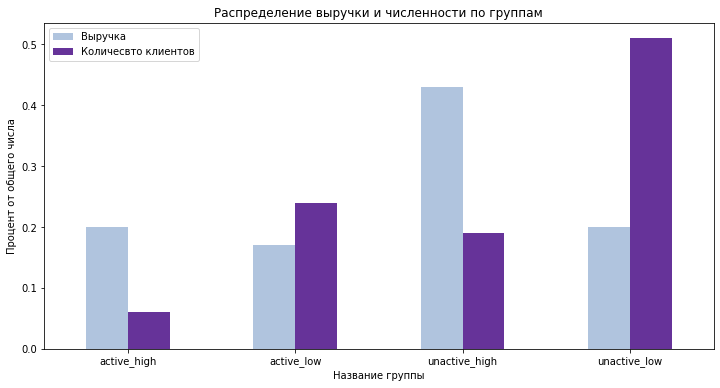

In [46]:

groups_bar = groups[['category', 'ratio_sum', 'ratio_number']]
groups_bar.columns = ['category', 'Выручка', 'Количесвто клиентов']


colors = ['lightsteelblue', 'rebeccapurple']
 

groups_bar.plot(kind='bar', colors = colors, figsize=(12, 6))

plt.gca().set_xticklabels(groups['category'])
plt.xticks(rotation=0) 

plt.xlabel('Название группы') 
plt.ylabel('Процент от общего числа')
plt.title('Распределение выручки и численности по группам')
plt.show()

Как видно на графике самую большую часть прибыли принесли клиенты из категории - unactive high (при этом, от общего числа они составляют меньше 20%). Интересно, что категория active_high (лишь 6% клиентов) принесли почти такой же доход, как и категории unactive_low (почти половина всей клиентской базы). Это, конечно, не самая показательная иллюстрация приница Парето, но близко к этому. При этом стоит помнить, что это данные без выбросов, то есть, если мы добавим сюда еще и аномально большие заказазы, то перекос в сторону категорий с высоким чеком будет еще выше 

### Статистические методы проверки 

У нас получилось 4 сегмента пользователей, чтобы доказать, что эти сегменты различны попарно сравним между собой чеки клиентов из каждой группы. В качестве метода проверки будем проводить тест Манна-Уитни (нам нужен именно непараметрический тест, так как  в сумме заказов есть большое количество выбросов). Напишем функцию, которая принимет на вход 2 выборки, возвращает pvalue и вывод о том можно ли отвергнуть нулевую гипотезу 

In [47]:
def mannwhitney (sample_1, sample_2):
    alpha = 0.05  # критический уровень статистической значимости 

    results = st.mannwhitneyu(sample_1, 
                             sample_2)
    
    print('p-значение: ', results.pvalue)
    
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

Проверим как работает функция на примере групп unactive_high и active_low. Сформулируем нулевую гиптезу:
- Клиенты, которые активно покупают и имеют низкий средний чек приносят такой же доход, как и клиенты, которые имеют высокий средний чек и покупают неактивно 

*(доход от каждого клиента соотвественно измеряется как сумма всех его покупок)*

In [48]:
mannwhitney(customers_new.query('category == "unactive_high"')['sum'],
                          customers_new.query('category == "active_low"')['sum'])

p-значение:  4.874400388068658e-146
Отвергаем нулевую гипотезу


Нулевая гипотеза может быть отвергнута, а значит разница между грппами статистически значима. У всего всего 4 группы, сравним все попарно (получается 6 сранений) и проведем оставшиеся 5 тестов 

In [49]:
mannwhitney(customers_new.query('category == "unactive_high"')['sum'],
                          customers_new.query('category == "unactive_low"')['sum'])

p-значение:  2.789032465668751e-220
Отвергаем нулевую гипотезу


In [50]:
mannwhitney(customers_new.query('category == "active_high"')['sum'],
                          customers_new.query('category == "active_low"')['sum'])

p-значение:  1.7610241700598158e-73
Отвергаем нулевую гипотезу


In [51]:
mannwhitney(customers_new.query('category == "active_high"')['sum'],
                          customers_new.query('category == "unactive_high"')['sum'])

p-значение:  0.002301613288831106
Отвергаем нулевую гипотезу


In [52]:
mannwhitney(customers_new.query('category == "active_high"')['sum'],
                          customers_new.query('category == "unactive_low"')['sum'])

p-значение:  8.248127757691692e-93
Отвергаем нулевую гипотезу


In [53]:
mannwhitney(customers_new.query('category == "active_low"')['sum'],
                          customers_new.query('category == "unactive_low"')['sum'])

p-значение:  0.019067219818223437
Отвергаем нулевую гипотезу


Разница между группами подтверждена статистически, значит можно говорить о том, что сегменты действительно разные 

###  Вывод 

В ходе сегментирования было выделено 4 следующие группы: 
- Самая многочисленная група получились - это группа с низким средним чеком и низкой активностью (примерно это половина всех клиентов). Неудивительно, что это многочисленная группа - такие клиенты всегда есть у любого магазина, однако стоит стретмиться к тому, чтобы из этой категории клиенты переходили хотя бы в active low. То есть для них актуальны всякие напоминательные рассылки или/и возможно реклама товаров из категорий уже купленных
- Группа active low - это те, кто покупает у нас активно, что уже неплохо, но в идеале нужно стремиться переводить из в active high. Таким клиентам скорее всего не стоит просто напоминать о магазине, а вот привлекать акциями имеет смысл
- Клиенты unactive high - давно ничего не покупали, однако они из малочисленной группы покупаелей с высоким чеком, таких клиентов стоит возвращать даже приорететнее тех, что в группе active_low
- Самая немногочисленная, но самая ценная категория это active_high. Таких клиентов нужно удерживать и поощерять их профиль потребления
Разница между ними была подтверждена статистически 

## Потебительские предпочтения

### Категории товаров

In [54]:
len(df['product'].unique())

2342

В магазине довольно большая база товаров, и цель данного проекта не в категоризации этих товаров. Воспользуемся информацией о товарах, как дополнительной характеритикой сегментов. Для это разобьем товары на 5 групп и посмотим какие товары покупают какие сегменты. Для начала выташим из наименования товара первое слово - это почти всегда ключевое опредление товара

In [55]:
def key_words(name):
    name_units = name.split(' ') 
    return name_units[0]

pd.set_option('display.max_colwidth', -1)
df['product2'] = df['product'].apply(key_words)

df.sample(5)

,date,customer_id,order_id,product,quantity,price,price_sum,date_month,product2
5684,2019-07-05 12:00:00,7e53225d-2df9-4484-95a5-3c73c6084a6c,14892,Рассада Дыни сорт Дина горшок 9х9 см P-9,1,38.0,38.0,2019-07,Рассада
1742,2019-02-08 13:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70167,Гладильная доска Dogrular Сити 110х33 см 223712,1,1139.0,1139.0,2019-02,Гладильная
418,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка с закругленными плечиками без перекладины с противоскользящим покрытием Valiant 226B10 черный,7,106.0,742.0,2018-10,Вешалка
1555,2019-01-21 09:00:00,8eabcaca-e8c8-4eee-9079-4ff5f612273a,69893,Щетка для мытья посуды КОЛИБРИ М5202 большая,100,34.0,3400.0,2019-01,Щетка
6048,2019-08-05 10:00:00,d10d338f-6871-49d4-a253-7f35da6a6867,72209,Коврик хлопковый 40х60 см цвета в ассортименте 6194,1,97.0,97.0,2019-08,Коврик


In [56]:
goods = df.groupby('product2')['date'].count().reset_index()
len(goods['product2'].unique())

461

Товаров стало существенно меньше, но их все равно достаточно много для катеоризации. При этом среди них много растений. Подгрузим дополнительную информацию с названиями растений 

In [57]:
url = 'https://tsvetem.ru/spisok-cvetov-po-alfavitu.html' #Список цветов по алфавиту

req = requests.get(url) # GET-запрос
soup = BeautifulSoup(req.text, 'lxml')

In [58]:
#возьмем со страницы только названия растений 
raw_values = []
for word in soup.find_all('li'):
    raw_values.append(word.text)
    
#row_values
#так же будем брать только первое слово

raw_values2 = []
for x in raw_values:
    units = x.split(' ')
    raw_values2.append(units[0])

#уберем запятые, если они есть в конце слов    
raw_values3 = [i.replace(',', '') for i in raw_values2]

#часть справочника для примера
print(raw_values3[15:30])

['Агава', 'Агапантус', 'Агератум', 'Аглаонема', 'Агростемма', 'Адениум', 'Адиантум', 'Адонис', 'Адромисхус', 'Азалия', 'Азистазия', 'Азорелла', 'Аир', 'Аквилегия', 'Аконит']


Присвоим все растениям, которые есть в выделеных первых словах категорию "растение", если ни есть в этом списке

In [59]:
df['product3'] = df['product2'].apply(lambda x: 'растение' if x  in raw_values3 else x)

In [60]:
goods = df.groupby('product3')['date'].count().reset_index()
#goods['product3'].unique()
len(goods['product3'].unique())

#goods.sort_values(by='date', ascending=False)
#len(goods.query('date > 1'))

338

Осталвшиеся названия вручую разделим на категории 

In [61]:
dishes = ['Tepмокружка', 'Банка', 'Бидон', 'Блюдо', 'Блюдце', 'Бульонница', 'Вилка', 'Губка', 'Измельчитель', 'Измерительный'
          'Картофелемялка', 'Кастрюля', 'Кружка', 'Кувшин', 'Ложка', 'Мантоварка', 'Мантоварка-пароварка', 'Масленка',
          'Миксер','Мини-сковорода', 'Миска', 'Нож', 'Ножеточка', 'Овощеварка', 'Овощечистка', 'Орехоколка', 'Просеиватель', 
          'Противень', 'Ковш','Половник','Венчик', 'Вкладыши', 'Емкость', 'Жестяная','Защитный', 'Пресс', 'Отделитель', 
        'Разделочная', 'Рыбочистка', 'Салатник', 'Сахарница', 'Сервировочная','Скалка', 'Сковорода', 'Крышка'
        'Соковарка', 'Соковыжималка', 'Сотейник', 'Стакан', 'Столовая', 'Столовый', 'Тарелка', 'Терка', 'Термокружка',
        'Термос', 'Термостакан','Толкушка', 'Тортница',  'Хлебница', 'Чайная', 'Чайник', 'Чайный', 'Фарфоровая','Электроштопор'
         ]

plants = ['Альбука', 'Аптения', 'Арбуз', 'Аргирантерум', 'Артемизия', 'Базилик', 'Баклажан',
       'Бакопа', 'Вигна', 'Виола', 'Газания', 'Гайлардия', 'Гиностемма', 'Глоксиния', 'Горох', 'Декабрист', 
       'Джункус', 'Дыня', 'Змееголовник', 'Импатиенс', 'Кабачок', 'Каланхое', 'Калла', 'Каллуна', 'Калоцефалус',
       'Кампанула', 'Капсикум', 'Капуста', 'Комнатное', 'Кориандр', 'Космея', 'Крассула', 'Крокусы', 'Лапчатка',
       'Левкой', 'Любисток','Мелисса', 'Мимоза', 'Многолетнее', 'Морковь', 'Нивянник', 'Нолина', 'Овсянница', 
        'Огурец', 'Однолетнее', 'Осина', 'Папоротник', 'Патиссон','Петрушка', 'Пуансетия', 'Пуансеттия','Ранункулус', 
        'Рассада', 'Розмарин', 'Сальвия', 'Сантолина', 'Седум', 'Сельдерей',  'Смолевка', 'Соланум', 'Солидаго', 
        'Суккулент',  'Тагетис',  'Томат',  'Хризолидокарпус', 'Цветок', 'Цветущее', 'Цикламен,', 'Цинерания', 'Циния',
       'Цитрофортунелла', 'Чабер', 'Эхинацея', 'растение', 'томата', 'Подвесное']

bath = ['Ёрш','Бак', 'Бельевые',  'Ванна','Вантуз', 'Держатель', 'Дозатор', 'Ерш', 'Запасная', 'Кипятильник', 'Корзина',
       'Корыто', 'Зубная', 'Мыло', 'Мыло-скраб', 'Мыльница','Паста', 'Таз', 'Настенная', 'Пена', 'Прищепки', 'Пробка',
        'Стиральный', 'Сушилка', 'Халат', 'Штора' ]

building = ['Веревка', 'Завертка','Карниз','Крепеж', 'Лестница', 'Лестница-стремянка', 'Линейка', 'Петля', 'Петля-стрела',
            'Сверло', 'Сверло-фреза','Стремянка', 'Стремянка-табурет','Стремянки', 'Стяжка', 'Уголок', 'Фал', 'Холодная', 
            'Шило', 'Шнур', 'Шпагат', 'Шпингалет', 'Шприц', 'Штанга', 'Штангенциркуль']              

Напишем функицю, которая будет присваивать категорию каждому товару из изначальной таблицы

In [62]:
def product_cat(product):
    if product in dishes:
        return 'Посуда'
    elif product in plants:
        return 'Растения'
    elif product in bath:
        return 'Принадлежности для ванны'
    elif product in building:
        return 'Стройматериалы'
    else: 
        return 'Товары для дома'   

In [63]:
df['product_cat'] = df['product3'].apply(product_cat)

In [64]:
df.groupby('product_cat')['product'].nunique()

product_cat
Посуда                      227
Принадлежности для ванны    268
Растения                    932
Стройматериалы              71 
Товары для дома             844
Name: product, dtype: int64

Получиось, что самые многочисленные категории - это товары для дома (по сути то, что не попало не в одну категорию) и растения. Посмотрим какие товары чаще покупают разные сегменты пользователей  

In [65]:
df.head()

,date,customer_id,order_id,product,quantity,price,price_sum,date_month,product2,product3,product_cat
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0,2018-10,Комнатное,Комнатное,Растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,194.0,2018-10,Комнатное,Комнатное,Растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0,2018-10,Радермахера,растение,Растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0,2018-10,Хризолидокарпус,Хризолидокарпус,Растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0,2018-10,Циперус,растение,Растения


In [66]:
pivot_customers = df.pivot_table(
        index = 'customer_id',
        columns ='product_cat',
        values = 'product',
        aggfunc = 'count'
)
pivot_customers_cat = pivot_customers.merge(customers_new, on = 'customer_id')
pivot_customers_cat.head()

,customer_id,Посуда,Принадлежности для ванны,Растения,Стройматериалы,Товары для дома,sum,orders_n,mean_check,date,diff,diff_n,category
0,000d6849-084e-4d9f-ac03-37174eaf60c4,NaN,NaN,4.0,NaN,NaN,555.0,1,555.0,2019-10-16 08:00:00,15 days 06:00:00,15,active_low
1,001cee7f-0b29-4716-b202-0042213ab038,NaN,1.0,NaN,NaN,NaN,442.0,1,442.0,2019-02-16 11:00:00,257 days 03:00:00,257,unactive_low
2,00299f34-5385-4d13-9aea-c80b81658e1b,NaN,NaN,NaN,NaN,1.0,914.0,1,914.0,2019-10-14 23:00:00,16 days 15:00:00,16,active_low
3,002d4d3a-4a59-406b-86ec-c3314357e498,NaN,NaN,NaN,NaN,1.0,1649.0,1,1649.0,2019-01-27 17:00:00,276 days 21:00:00,276,unactive_high
4,003bbd39-0000-41ff-b7f9-2ddaec152037,NaN,NaN,NaN,NaN,1.0,2324.0,1,2324.0,2019-09-29 17:00:00,31 days 21:00:00,31,active_high


In [67]:
pivot = pivot_customers_cat.groupby('category').agg({
    'Посуда' : 'sum',
    'Принадлежности для ванны': 'sum', 
    'Растения': 'sum', 
    'Стройматериалы': 'sum',
    'Товары для дома' : 'sum'}).reset_index()
pivot

,category,Посуда,Принадлежности для ванны,Растения,Стройматериалы,Товары для дома
0,active_high,22.0,43.0,114.0,15.0,141.0
1,active_low,62.0,163.0,618.0,30.0,360.0
2,unactive_high,51.0,78.0,744.0,30.0,382.0
3,unactive_low,148.0,229.0,1041.0,28.0,571.0


Очевидный вывод, который сразу бросается в глаза: во всех группах товаров категория unactive_low покупает больше всего. Но как мы знаем из исследовательского анализа, это не та группа, которая приносит больше всего выручки, просто это численно самая большая группа, поэтому в абсолютных числах они будут покупать больше, но на небольшие суммы (и скорее всего только один раз).
Что касается имеено потребительских предпочтений, то неактивные покупатели чаще всего приходили в магазин за растениями. Самые ценные клиенты магазина (активные и с высоким средним чеком) больше всего интересуются товарами для дома. Другая категория активных клиентом active_low также больше всего покупает растения. 

### Вывод 

Даже поверхностная категоризация товаров дает определенные идеи для дополнения сегментации. А именно: 
- категория unactive_low больше всего покупает почти во всех категориях - и это логично, так как это самая большая, но и самая инертная категория (это клиенты, которые купили что-то недорогое один раз довольно давно). Чаще всего этой покупкой были растения, потому, например, чтобы попытаться вытянуть их в категорию active low в настройках таргетинга можно учесть, что таким клиентам потенциально интересны недорогие растения 
- категория unactive_high также в основном интересуется растениями, однако мы знаем, что эти клиенты платят больше, поэтому их можно заинтересовать более дорогим, но разнообразным ассортиментом этой категории 
- категория active_low тоже часто покупает растения, но это те покупатели, которые итак часто к нам приходят, поэтому им смело можно рекомендовать недорогие товары и из других категорий - товары для дома и принадлежности для ванны
- самая ценная категория - те, кто покупает активно и на большую сумму - менее, чем все остальные увлечен растениями, а  больше всего покупают товары для дома. Желательно, чтобы их профиль потребления не менялся, поэтому им можно рекомендовать те же товары 

Также стоит заметить, что для магазина особенно ценны клиенты с высоким средним чеком - даже если не учитывать выбросы (в виде огромных покупок), эти клиенты, будучи в меньшинстве,приносят почти половину дохода. Поэтому можно предложить настроить таргетинг для клиентов групп low исходя из рекомендаций выше, а клиентов групп high анализировать подробнее 

## Общие выводы исследования 

Анализа транзацкий покупателей интернет-магазина дал следующие выводы: 

* Выявлен очень маленький процент (6%) тех покупателей, которые возвращаются за повторными покупками. Если это техническая особенность, тогда возможно стоит сделать регистрацию обязательной - так мы сможем эффективнее искать лояльных клиентов. На имеющихся же данных можно говорить о том, что в основном покупатели совершают 1 заказ.

* Средний чек у 50% покупателей не превышает 700 рублей, а у 75% - 1447 руб. То есть большинство клиентов совершают в нашем магазине недорогие покупки, однако те, клиенты, которые тратят на один заказ больше этой суммы, вносят более существенный вклад в выручку компании

* Клиенты были поделены на 4 сегмента исходя из их активности и среднего чека, и разница между этими сегментами была подтверждена статистически. Самая многочисленная группа - это группа с низким средним чеком и низкой активностью (примерно это половина всех клиентов). В идеале стоит стремиться, чтобы эти клиенты переходили хотя бы в active low. Таких клиентом можно заинтересовать напоминательными рассылками или/и возможно рекламой товаров из категорий уже купленных. Группа active low - это те, кто покупает у нас активно, но не на большие суммы. У таких клиентов стоит стремиться к тому, чтобы увеличивать их средний чек. Клиенты unactive high - давно ничего не покупали, однако они из малочисленной группы покупателей с высоким чеком, таких клиентов стоит возвращать даже приоритетнее чем мотивировать тех, что в группе active_low. Самая немногочисленная, но самая ценная категория это active_high. Это идеальные клиенты, их нужно удерживать и поощрять.

* Для категорий клиентов с низким средним чеком в качестве дополнения к сегментизации можно воспользоваться общими рекомендациями по категориям товаров. Так, клиентам из категории unactive_low, чтобы побудить их к повторным покупкам и напомнить о магазине, можно рекомендовать недорогие растения. А клиентам из категории active_low с целью повышения их среднего чека можно реккомендовать также растения, но еще и товары из других категорий (товары для дома и принадлежности для ванны). Что касается клиентов с высоким средним чеком, то в рамках этого исследования мы бы порекомендовали заинтересовать их более дорогими товарами категории растения (для тех кто покупает неактивно) и товарами для дома (для тех кто покупает активно). Однако, ввиду того, что эти покупатели наиболее ценны, возможно, стоит проанализировать их предпочтения более детально.

* Техническая деталь - в данных было обнаружено довольно много скрытых дубликатов (около четверти от всего изначального датасета). Скорее всего, это говорит о сбоях в сборе данных, которые было бы желательно устранить 